In [1]:
## Exercice 1

In [2]:
%matplotlib inline   
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2  

In [3]:
def f(x):
    return x


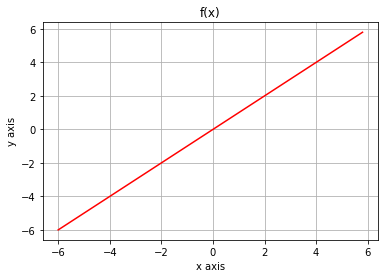

In [4]:
x = np.arange(-6,6,0.2)
y = f(x)

plt.plot(x,y,'r-')
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.title('f(x)')
plt.grid(True)
plt.show()

In [5]:
def sigmoid(x):
    sig = 1/(1+np.exp(-x))
    return sig

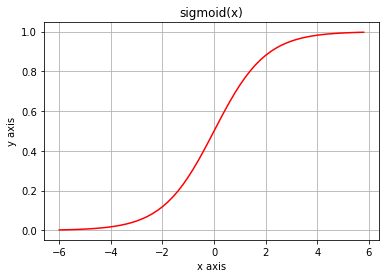

In [6]:
z = sigmoid(x)

plt.plot(x,z,'r-')
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.title('sigmoid(x)')
plt.grid(True)
plt.show()

In [7]:
## Exercice 2

In [8]:
# 2.
fid = open('GTI770_label_data_set.csv', 'r') 
next(fid) # skip les headers (la premiere ligne)

classDict = {}

X = np.zeros((100, 3, 424, 424), dtype=int)
Y = np.zeros((100, 2), dtype=object)

count = 0
for line in fid:
    element = line.rstrip('\n').split(',')
    
    if element[1] not in classDict:
        classDict[element[1]] = 0     
    elif element[1] in classDict and classDict[element[1]] < 50:
        classDict[element[1]] += 1;
    else:
        continue
    
    imagePath = 'images/' + element[0] + '.jpg'
    if not os.path.exists(imagePath):
        classDict[element[1]] -= 1    # S'assure d'avoir des images qui existe
        continue
        
    img = cv2.imread(imagePath).reshape(3,424,424)
    img = img[:, :, ::-1]
    
    X[count] = img
    Y[count] = [count, element[1]]
    
    count += 1
    if count >= 100:
        break

fid.close() 

Smooth :


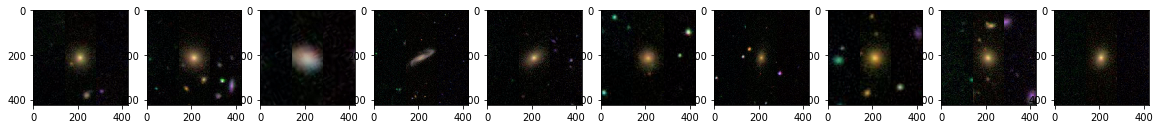

Spiral :


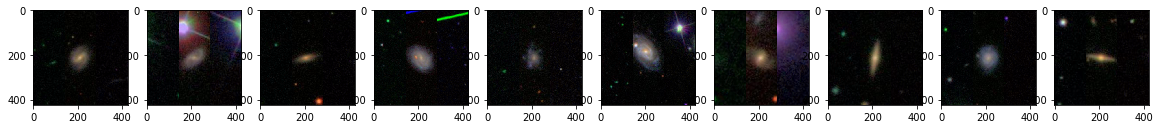

In [17]:
# 3.

def GenerateRandomNumbersList(ArangeLength, GeneratedSetLength):
    a = np.arange(ArangeLength)
    np.random.shuffle(a)
    randomSet = a[:GeneratedSetLength]
    return randomSet

rand1 = GenerateRandomNumbersList(50, 10)
rand2 = GenerateRandomNumbersList(50, 10)

YSorted = Y[Y[:,1].argsort()]
listSmooth = YSorted[:len(YSorted)//2]
listSpiral = YSorted[len(YSorted)//2:]

def RandomList(list, randNumbers):
    listRand = np.zeros((10, 3, 424, 424), dtype=int)
    for i in range(0, len(randNumbers)):
        randY = list[randNumbers[i]]        
        listRand[i] = X[randY[0]]
    return listRand
    
listRandSmooth = RandomList(listSmooth, rand1)
listRandSpiral = RandomList(listSpiral, rand2)

def ShowImageList(imageList):
    f, axarr = plt.subplots(1, len(imageList), figsize=(20,20))
    for i in range(0, len(imageList)):
        axarr[i].imshow(imageList[i].reshape(len(imageList[0][0]),len(imageList[0][0][0]),3))      
    plt.show()
    
print("Smooth :")
ShowImageList(listRandSmooth)
print("Spiral :")
ShowImageList(listRandSpiral)

In [12]:
#4.
Y_train = np.concatenate((listSmooth[:35], listSpiral[:35]), axis=0)
Y_test = np.concatenate((listSmooth[-15:], listSpiral[-15:]))

def GenerateXFromY(listY):
    listX = np.zeros((len(listY), 3, 424, 424), dtype=int)
    for i in range(len(listY)):
        imageIndex = listY[i]
        listX[i] = X[imageIndex[0]]
    return listX

X_train = GenerateXFromY(Y_train)
X_test = GenerateXFromY(Y_test)

#----------------------
#For debug :
# print(len(Y_train))
# print(Y_train)
# print(len(Y_test))
# print(Y_test)
# print(len(X_train))
# print(len(X_test))
#----------------------

In [13]:
#5.

def crop(img,cropx,cropy):
    x,y,rgb = img.shape #Prend les valeurs de l'image
    startx = x//2-(cropx//2) #Trouve la nouvelle coordonnée startx
    starty = y//2-(cropy//2) #Trouve la nouvelle coordonnée starty
    return img[startx:startx+cropx,starty:starty+cropy] #Réajuste l'image selon les nouvelle coordonnée et la longueur du crop

X_train_crop = np.zeros((len(X_train), 3, 50, 50), dtype=int)
for i in range(0, len(X_train)):
    X_train_crop[i] = crop(X_train[i].reshape(424, 424, 3),50,50).reshape(3, 50, 50)
    
#-----------------------
#For Debug :
# print(len(X_train_crop))
# print(len(X_train_crop[0][0]))
# print(len(X_train_crop[0][0][0]))
#-----------------------    

Smooth - cropped (left) vs untouched (right) :


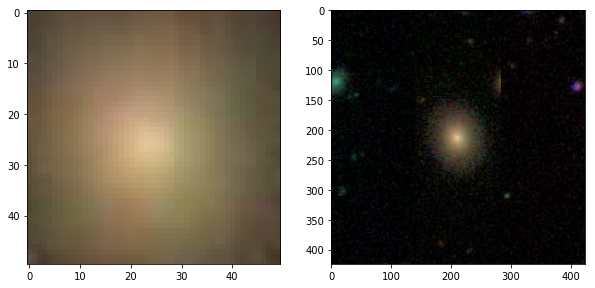

Spiral - cropped (left) vs untouched (right) :


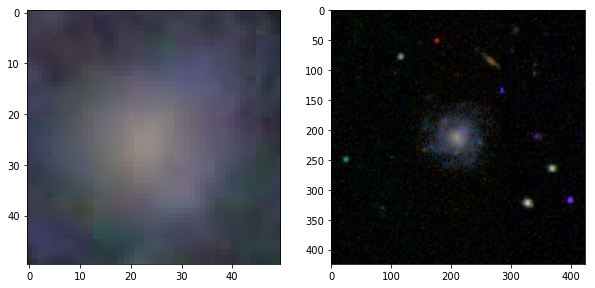

In [14]:
#6.

def showCropComparison(imgIndex):
    img = X_train[imgIndex].reshape(424,424,3)
    img_cropped = np.zeros((1, 50, 50, 3), dtype=int)
    img_cropped[0] =  X_train_crop[imgIndex].reshape(50,50,3)
    f, axarr = plt.subplots(1, 2, figsize=(10,10))
    axarr[0].imshow(img_cropped[0])
    axarr[1].imshow(img)
    plt.show()
    
print("Smooth - cropped (left) vs untouched (right) :")
showCropComparison(0)
print("Spiral - cropped (left) vs untouched (right) :")
showCropComparison(58)


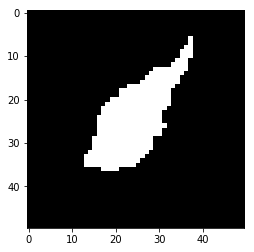

In [15]:
#7.

def RgbToGray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114]) #Transforme l'image couleur en grayscale

X_train_binary = np.zeros((len(X_train_crop), 50, 50), dtype=float)
for i in range(0, len(X_train_crop)):
    grayscale = RgbToGray(X_train_crop[i].reshape(50,50,3))  
    ret,thresh_img = cv2.threshold(grayscale,128,255,cv2.THRESH_BINARY)
    X_train_binary[i] = thresh_img

#-------------------------------------------
#For debug :
plt.imshow(X_train_binary[45], cmap=plt.cm.gray)
#plt.imshow(X_train_crop[52].reshape(50,50,3))
#-------------------------------------------

In [13]:
#8.

#Le fait d'avoir une matrice avec le nombre de pixels noires et blanches permet de faire le différence entre
#les galaxies de type "spiral" et "smooth". Les spirals ont tendence à être plus étendu et on donc moins de pixels blanches que 
#les galaxies de types smooth qui ont tendence de faire des taches blanches plus prononcées.

X_train_plot = np.zeros((len(X_train_binary), 2), dtype=int)
for i in range(0, len(X_train_binary)):
    X_train_plot[i][0] = np.sum(X_train_binary[i] == 255) #Number of white pixels
    X_train_plot[i][1] = np.sum(X_train_binary[i] == 0) #Number of black pixels

#-------------------------------------------
#For debug :
#print(X_train_plot)
#-------------------------------------------

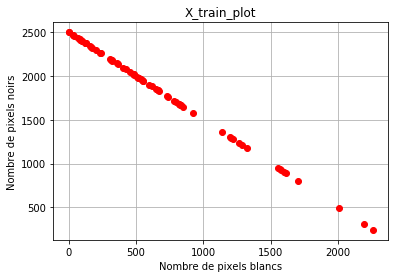

In [14]:
#9.
X_coord = np.zeros(len(X_train_binary), dtype=int)
Y_coord = np.zeros(len(X_train_binary), dtype=int)

for i in range(0, len(X_train_plot)):
    X_coord[i] = X_train_plot[i][0]
    Y_coord[i] = X_train_plot[i][1]
    
plt.plot(X_coord, Y_coord, 'ro')
plt.xlabel('Nombre de pixels blancs')
plt.ylabel('Nombre de pixels noirs')
plt.title('X_train_plot')
plt.grid(True)
plt.show()